In [6]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Analyzing sample data recorded from my Smartphone

### Accelerometer while Walking

In [7]:
datawalk = pd.read_csv("dataset/walking/acc.csv")

In [16]:
datawalk.head(5)

,Timestamp,Milliseconds,X,Y,Z
0,2019-10-29 16:33:55,15,-0.781097,4.390778,8.850006
1,2019-10-29 16:33:55,21,-0.508163,4.464996,8.873962
2,2019-10-29 16:33:55,42,0.152634,4.771454,8.378357
3,2019-10-29 16:33:55,61,-0.584778,4.974960,7.367996
4,2019-10-29 16:33:55,82,-0.905594,4.850464,6.817337


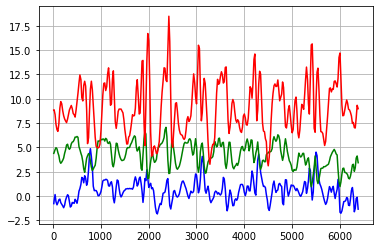

In [22]:
# plt.subplot(3,1,1)
plt.plot(datawalk["Milliseconds"],datawalk["X"],c="blue")
plt.grid()
# plt.subplot(3,1,2)
plt.plot(datawalk["Milliseconds"],datawalk["Y"],c="green")
# plt.grid()
# plt.subplot(3,1,3)
plt.plot(datawalk["Milliseconds"],datawalk["Z"],c="red")
# plt.grid()
plt.show()

### Accelerometer while Jumping

In [11]:
datajump = pd.read_csv("dataset/jumping/acc.csv")

In [13]:
datajump.head(5)

,Timestamp,Milliseconds,X,Y,Z
0,2019-10-29 16:34:08,2,-1.599915,2.884827,8.648895
1,2019-10-29 16:34:08,21,0.480652,4.034042,10.710312
2,2019-10-29 16:34:09,42,-0.891235,3.222412,11.282516
3,2019-10-29 16:34:09,61,-0.668579,3.612671,9.340820
4,2019-10-29 16:34:09,81,1.072006,5.049179,6.822128


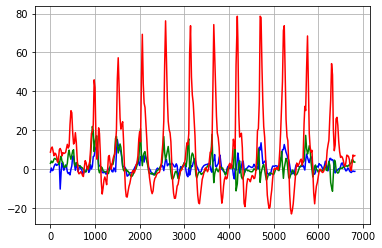

In [23]:
# plt.subplot(3,1,1)
plt.plot(datajump["Milliseconds"],datajump["X"],c="blue")
plt.grid()
# plt.subplot(3,1,2)
plt.plot(datajump["Milliseconds"],datajump["Y"],c="green")
# plt.grid()
# plt.subplot(3,1,3)
plt.plot(datajump["Milliseconds"],datajump["Z"],c="red")
# plt.grid()
plt.show()

### Accelerometer while Sitting

In [8]:
datasit = pd.read_csv("dataset/sitting/acc.csv")

In [10]:
datasit1.head(5)

,Timestamp,Milliseconds,X,Y,Z
0,2019-10-29 16:34:35,0,0.068039,-0.130844,0.068329
1,2019-10-29 16:34:35,20,0.117050,0.005508,0.116257
2,2019-10-29 16:34:35,41,0.086151,-0.028580,0.118393
3,2019-10-29 16:34:35,60,0.073364,-0.050949,0.104538
4,2019-10-29 16:34:35,80,0.050995,-0.060532,0.086426


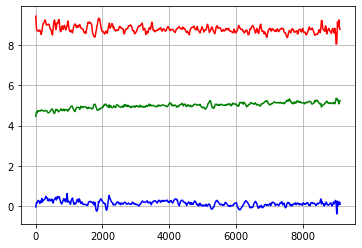

In [12]:
# plt.subplot(3,1,1)
plt.plot(datasit["Milliseconds"],datasit["X"],c="blue")
plt.grid()
# plt.subplot(3,1,2)
plt.plot(datasit["Milliseconds"],datasit["Y"],c="green")
# plt.grid()
# plt.subplot(3,1,3)
plt.plot(datasit["Milliseconds"],datasit["Z"],c="red")
# plt.grid()
plt.show()

## Preparing UCI HAR datset

In [30]:
SENSOR_TYPE = [
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_"
]
ACTIVITY = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

data_path_train_x = "dataset/UCI HAR Dataset/train/Inertial Signals/"
data_path_test_x = "dataset/UCI HAR Dataset/test/Inertial Signals/"
data_path_train_y = "dataset/UCI HAR Dataset/train/y_train.txt"
data_path_test_y = "dataset/UCI HAR Dataset/test/y_test.txt"

In [31]:
def load_x_data(path):
    sensor_data = []
    for sensors in SENSOR_TYPE:
        sensor_data_path = path + sensors + "train.txt"
        file = open(sensor_data_path,'r')
        sensor_data.append(
        [np.array(serie, dtype=np.float32) for serie in [row.replace('  ', ' ').strip().split(' ') for row in file]])
        file.close()
    return np.transpose(np.array(sensor_data), (1, 2, 0))

In [32]:
x_train = load_x_data(data_path_train_x)
print(len(x_train),len(x_train[0]),len(x_train[0][0]))

7352 128 6


In [33]:
def load_y_data(path):
    file = open(path,'r')
    y_data = np.array([elem for elem in [row.replace('  ', ' ').strip().split(' ') for row in file]],dtype=np.int32)
    file.close()
    return y_data

In [34]:
y_train = load_y_data(data_path_train_y)
print(len(y_train))

7352


## Preparing the Dataset for Use